# Tick 1

In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
import ucamcl

In [2]:
GRADER = ucamcl.autograder('https://markmy.solutions', course='scicomp').subsection('tick1a')

Waiting for you to log in .. done.


##### The aim of this tick is to model infections in a population of individuals. We will be focusing on the effects of the size of peoples' home bubbles and their interactions with people outside their own bubble.

## Question 1a

#### 1)

In [3]:
def random_sizes(N, avg_size):
    return np.random.geometric(1/avg_size, size=N)

##### This function generates a vector of N sizes for loci.

In [4]:
def trunc_sizes(sizes):
    N = len(sizes)
    cummul = np.cumsum(sizes)
    cummul[cummul>N] = 0
    cummul[cummul==0] = sizes[0]
    maxind = np.argmax(cummul) + 1
    if maxind == 1: sizestrunc = sizes[:maxind]
    else: sizestrunc = sizes[:maxind+1]
    lastind = np.size(sizestrunc) - 1
    diff = (np.sum(sizestrunc) - N)
    sizestrunc[lastind] -= diff
    sizestrunc = np.trim_zeros(np.array(sizestrunc))
    return (sizestrunc)

##### This function truncates the vector created by the random_sizes function so that the sum of all the elements adds to N instead of having a cardinality of N.

In [5]:
q = GRADER.fetch_question('q1')
ans = trunc_sizes(q.s)

In [6]:
GRADER.submit_answer(q, ans)

Correct!


True

#### 2)

##### The loc_sizes parameter is a vector of locus sizes that sum to N.

In [7]:
def person_in(loc_sizes):
    loc_sizes = np.array(loc_sizes)
    M = np.size(loc_sizes)
    P = np.repeat(np.arange(0, M), loc_sizes)
    return (P)

##### This function computes a vector of length N, that contains the index of the locus that each person is in.

In [8]:
def first_occ(loc_sizes):
    loc_sizes = np.array(loc_sizes)
    M = np.size(loc_sizes)
    F = np.cumsum(loc_sizes)
    A = np.zeros(M, dtype=int)
    A[1:] = F[:-1]
    return A

##### This function computes a vector of length M, where M is the length of the loc_sizes vector. The vector contains the index of the first person in each locus

In [9]:
q = GRADER.fetch_question('q2')
ans = {'person_in': person_in(q.loc_sizes), 'first_occ': first_occ(q.loc_sizes)}

In [10]:
GRADER.submit_answer(q, ans)

Correct!


True

#### 3)

##### The infected parameter is a vector of length N which contains information on whether the person at each index is infected (using 0s and 1s).

In [11]:
def exposure(infected, loc_sizes):
    infected = np.array(infected)
    loc_sizes = np.array(loc_sizes)
    per_in = person_in(loc_sizes)
    fi_occ = first_occ(loc_sizes)
    
    a = np.cumsum(loc_sizes)
    breaks = np.zeros(np.size(a)+1, dtype=int)
    breaks[1:] = a
    
    sums = np.add.reduceat((infected > 0).astype(int), breaks[:-1], dtype=np.int)
    
    ans = np.repeat(sums, loc_sizes)
    return ans

##### This function returns a vector of length N, where each entry i counts the number of infected people in the locus that person i is on.

In [12]:
q = GRADER.fetch_question('q3')
ans = exposure(np.array(q.infected), q.loc_sizes)

In [13]:
GRADER.submit_answer(q, ans)

Correct!


True

#### 4)

##### These are helper functions used by the sim function to simulate a single day's infections and recoveries respectively.

In [14]:
def sim_infections(infected, exposed, prob_infect):
    infected[infected == 2] = 1
    original_total = np.sum((np.copy(infected) > 0).astype(int))
    infected[((np.random.rand(*infected.shape) < prob_infect).astype(int)==1) & (exposed > 0) & (infected == 0)] = 2
    return ((np.sum((infected > 0).astype(int)) - original_total))
    
def sim_recoveries(infected, exposed, prob_recover):
    original_infected = np.copy(infected)
    original_total = np.sum((original_infected > 0).astype(int))
    probs = np.random.rand(*infected.shape)
    probs = (probs < prob_recover).astype(int)
    infected[(probs==1) & (infected == 1)] = -1
    total = np.sum((infected > 0).astype(int))
    total_recovered = (original_total - total)
    return (total_recovered)

##### The sim function returns a matrix with T rows (for T days) and 4 columns (for daily new infections, daily new recoveries, cummulative total infections, cummulative total recoveries). In order to fill the matrix, the sim function simmulates infections and recoveries for each day.

In [15]:
def sim(N, T, n0, avg_loc_size=2.1, prob_infect=0.07, prob_recover=1/10):
    loc_sizes = trunc_sizes(random_sizes(N, avg_loc_size))
    infected = np.zeros(N, dtype=int)
    infected[:n0] = 1
    infected = np.random.permutation(infected)
    exposed = exposure(infected, loc_sizes)
    
    A = np.zeros((T, 4), dtype=int)
    
    for x in range (0, T):
        infected_today = sim_infections(infected, exposed, prob_infect)
        exposed = exposure(infected, loc_sizes)
        recovered_today = sim_recoveries(infected, exposed, prob_recover)
        exposed = exposure(infected, loc_sizes)
        total_infections = np.sum((infected != 0).astype(int))
        total_recoveries = np.sum((infected == -1).astype(int))
        a = [infected_today, recovered_today, total_infections, total_recoveries]
        A[x] = a
        infected = np.random.permutation(infected)
        exposed = exposure(infected, loc_sizes)
        
    
    return A

In [16]:
q = GRADER.fetch_question('q4')
x = sim(N=q.N, T=q.T, n0=q.n0, avg_loc_size=q.avg_loc_size, prob_infect=q.prob_infect, prob_recover=q.prob_recover)
ans = x[-1,3]/q.N

In [17]:
GRADER.submit_answer(q, ans)

Correct!


True

#### 5)

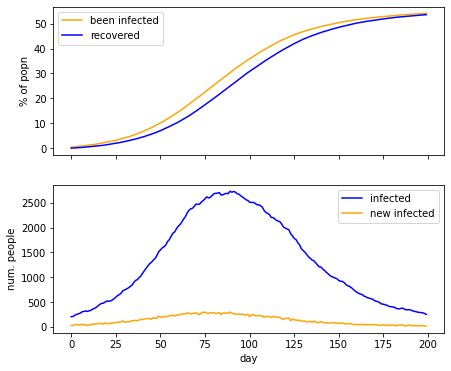

In [18]:
x = sim(N=50000, T=200, n0=200)
day_num = np.arange(0,200)
total_infected_percent = (x[:, 2]/50000) * 100
total_recovered_percent = (x[:, 3]/50000) * 100
total_infected = x[:, 2] - x[:, 3]
daily_infected = x[:, 0]

data = pandas.DataFrame({
'day'          : day_num,
'been_infected': total_infected_percent,
'recovered'    : total_recovered_percent,
'infected'     : total_infected,
'new_infected' : daily_infected
},
columns = ['day', 'been_infected', 'recovered', 'infected', 'new_infected'])


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7, 6))
ax1.plot(data.day, data.been_infected, label='been infected', color='orange')
ax1.plot(data.day, data.recovered, label='recovered', color='blue')
ax1.legend()
ax1.set_ylabel('% of popn')
ax2.plot(data.day, data.infected, label='infected', color='blue')
ax2.plot(data.day, data.new_infected, label='new infected', color='orange')
ax2.legend()
ax2.set_ylabel('num. people')
plt.xlabel('day')
plt.show()

##### This series of instructions generate graphs for the percentage of population that has been infected and recovered against time, and the number of currently infected and new infections against time.

## Question 1b

In [19]:
GRADER = ucamcl.autograder('https://markmy.solutions', course='scicomp').subsection('tick1b')

Waiting for you to log in .. done.


#### 6)

##### The R number can be estimated using R = days * N/D where N is the total number of new infections, D is the sum (over time) of the number of infected people at the start of each day and days is the average number of days a person is infected (1/prob_recover). N and D are computed over a specified range of days.

In [20]:
def r(X, t0, t1, days):
    
    XN = X[t0:t1]
    N = np.sum(XN[:, 0])
    
    XD = X[t0-1:t1-1]
    D = np.sum(XD[:, 2])
    
    R = days*N/D
    return R

##### This function computes the R number using the matrix generated by the simulator above.

In [21]:
q = GRADER.fetch_question('q6')
ans = r(np.array(q.X), t0=q.t0, t1=q.t1, days=q.days)

In [22]:
GRADER.submit_answer(q, ans)

Correct!


True

#### 7)

In [23]:
def bubbles(N, num_households):
    return np.random.choice([1,2,3,4,5,6], p=[.29,.35,.15,.14,.05,.02], size=(num_households,N)).sum(0)

##### This function generates a vector of household bubble sizes based on the distribution of household sizes in the UK.

In [24]:
def sim_infections2(infected, exposed, prob_infect):
    infected[infected == 2] = 1
    original_infected = np.copy(infected)
    original_total = np.sum((original_infected > 0).astype(int))
    probs = np.random.rand(*infected.shape)
    probs = (probs < prob_infect).astype(int)
    infected[(probs==1) & (exposed > 0) & (infected == 0)] = 2
    total = np.sum((infected > 0).astype(int))
    total_infected = (total - original_total)
    return (total_infected)
    
def sim_recoveries2(infected, prob_recover):
    original_infected = np.copy(infected)
    original_total = np.sum((original_infected > 0).astype(int))
    probs = np.random.rand(*infected.shape)
    probs = (probs < prob_recover).astype(int)
    infected[(probs==1) & (infected == 1)] = -1
    total = np.sum((infected > 0).astype(int))
    total_recovered = (original_total - total)
    return (total_recovered)

##### These are the modified helper functions.

##### The parameter n0 is an initial number of infected people that are randomly distributed throughout the households.

In [25]:
def sim2(N, T, n0, avg_loc_size, prob_infect_outside, prob_recover, prob_infect_home, num_households):
    bubble_sizes = trunc_sizes(bubbles(N, num_households))
    loc_sizes = trunc_sizes(random_sizes(N, avg_loc_size))
    
    infected = np.zeros(N, dtype=int)
    infected[:n0] = 1
        
    A = np.zeros((T, 4), dtype=int)
    
    for x in range (0, T):
        rand =  np.random.permutation(np.arange(0,N))
        infected = infected[rand]
        exposed = exposure(infected, loc_sizes)
        infected_today_outside = sim_infections2(infected, exposed, prob_infect_outside)
        exposed = exposure(infected, loc_sizes)

        infected[rand] = np.copy(infected)
        exposed = exposure(infected, bubble_sizes)
        infected_today_home = sim_infections2(infected, exposed, prob_infect_home)
        exposed = exposure(infected, bubble_sizes)
        
        infected_today = infected_today_outside + infected_today_home
        
        recovered_today = sim_recoveries2(infected, prob_recover)
        exposed = exposure(infected, bubble_sizes)
        
        total_infections = np.sum((infected != 0).astype(int))
        
        total_recoveries = np.sum((infected == -1).astype(int))
        
        a = [infected_today, recovered_today, total_infections, total_recoveries]
        A[x] = a
        
        exposed = exposure(infected, loc_sizes)
        
    return A

##### This is a modified simulator that, simulates people travelling from a constant home bubble to and from a random public loci. There is a chance of being infected at both loci and then a chance of recovering at the end of the day.

In [26]:
q = GRADER.fetch_question('q7')
x = sim2(N=q.N, T=q.T, n0=q.n0, avg_loc_size=q.avg_loc_size,
         prob_infect_outside=q.prob_infect, prob_recover=q.prob_recover, prob_infect_home=q.prob_infect_home,
         num_households=q.num_households)
ans = x[-1,3] / q.N

In [27]:
GRADER.submit_answer(q, ans)

Correct!


True

#### 8)

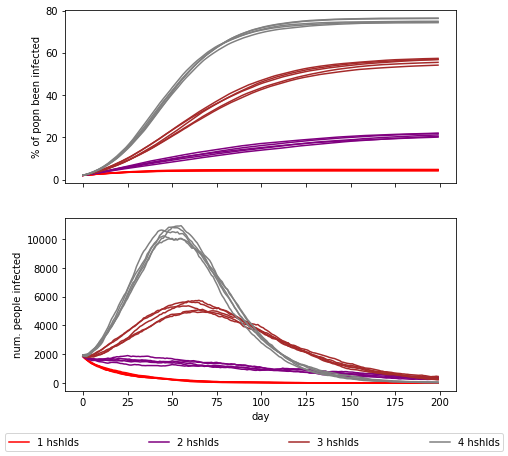

CPU times: user 1min 12s, sys: 56.1 ms, total: 1min 12s
Wall time: 1min 12s


In [28]:
%%time
import math

day_num = np.arange(0,200)
data = pandas.DataFrame({'day' : day_num}, columns=['day'])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,7))

colours = ['red', 'purple', 'brown', 'grey']

for m in range(1, 5):
    for n in range(0, 5):
        x = sim2(N=100000, T=200, n0=2000, prob_infect_home=.2, prob_infect_outside=.01, avg_loc_size=2.1, prob_recover=1/10,
                 num_households=m)
        total_infected_percent = (x[:, 2]/100000) * 100
        total_infected = x[:, 2] - x[:, 3]
        data['been_infected_'+str(m)+'_'+str(n)] = total_infected_percent
        data['infected_'+str(m)+'_'+str(n)] = total_infected
        label1 = "data.been_infected_" + str(m) + '_' + str(n)
        label2 = "data.infected_" + str(m) + '_' + str(n)
        ax1.plot(data.day, eval(label1), label= str(m) + ' hshlds', color=colours[m-1])
        ax2.plot(data.day, eval(label2), label= str(m) + ' hshlds', color=colours[m-1])

        
ax1.set_ylabel('% of popn been infected')
ax2.set_ylabel('num. people infected')
plt.xlabel('day')
handles, labels = ax2.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
h = handles[[0, 5, 10, 15]]
l = labels[[0, 5, 10, 15]]
fig.legend(h, l, loc='lower center', mode = "expand", ncol = 4)
plt.show()

##### This set of instructions generates plots, using data from the simulator. We vary the sixe of household bubbles from 1 to 4, repeating each simulation 5 times. We plot the percentage of the population that has been infected against time and the number of currently infected people against time.

#### 9)

In [29]:
def r2(X, t0, t1, days):
    
    XN = X[t0:t1]
    N = np.sum(XN[:, 0])
    
    XD = X[t0-1:t1-1]
    D = np.sum(XD[:, 2] - XD[:, 3])
    
    R = days*N/D
    return R

##### This function generates the R number over a certain timespan to try and capture the R value of the initial wave.

In [30]:
ans = []

for b in range(1, 5):
    x = sim2(N=100000, T=200, n0=2000, prob_infect_home=.2, prob_infect_outside=.01, avg_loc_size=2.1, prob_recover=1/10, 
             num_households=b)
    R = r2(x, 10, 25, 10)
    ans.append(R)

##### This series of instructions, once again, runs simulations for the aforementioned bubble sizes and uses the function above to generate their R values for an initial wave.

In [31]:
GRADER.submit_answer(GRADER.fetch_question('q9'), ans)

Correct!


True